In [1]:
import numpy as np
from neuralStellar2 import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T
import theano
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc("font", family="serif", size=14)
import HBMplot

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#loading in NN
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'], Teff_scaling=5000)
m1.loadModel('Ran_files/big_grid_146(h)/000_best_model.h5')
m1.getWeights()

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5)                 20        
_________________________________________________________________
dense_33 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 128)             

In [3]:
#loading in cluster csv
cluster_df = pd.read_csv('data_collection/NNcluster/NNcluster_Y_0.26.csv')
N = len(cluster_df.index)
print('There are {} stars in cluster.'.format(N))

There are 30 stars in cluster.


## HBM!!!

In [4]:
prior_mids = [1, 0, 0.28]
prior_widths = [2, 0.4, 0.04]
max_mass = 1.7

model = pm.Model()
with model:
    Age_mu = pm.Deterministic('mean_age',pm.Beta('a',1.1,1.1)*prior_widths[0]+prior_mids[0]-0.5*prior_widths[0])
    Age_sigma = pm.Lognormal('spread_age',T.log(0.15),0.4)
    feh_mu = pm.Deterministic('mean_feh',pm.Beta('e',1.1,1.1)*prior_widths[1]+prior_mids[1]-0.5*prior_widths[1])
    Y_mu = pm.Deterministic('mean_Y',pm.Beta('f',1.1,1.1)*prior_widths[2]+prior_mids[2]-0.5*prior_widths[2])
    MLT_mu = pm.Deterministic('mean_MLT',pm.Beta('g',1.1,1.1)*0.6+1.7)
    
    M = pm.Deterministic('mass', pm.Beta('d',1.1,1.1,shape=N)*(max_mass-0.8)+0.8)
    Age = pm.Deterministic('age',pm.Normal('age_normal', 0, 1, shape=N)*Age_sigma+Age_mu)
    feh = pm.Deterministic('feh',T.ones(N)*feh_mu)
    Y = pm.Deterministic('Y',T.ones(N)*Y_mu)
    MLT = pm.Deterministic('MLT',T.ones(N)*MLT_mu)
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    true_Teff = pm.Deterministic('true_Teff', 10**obs[1,:]*5000)
    true_L = pm.Deterministic('true_L', (10**obs[0,:])**2*(true_Teff/5776.02970722)**4)
    
    obs_L = pm.Normal('obs_L',true_L,sigma=cluster_df['cal_lum_err'], observed=cluster_df['cal_lum'])
    obs_Teff = pm.Normal('obs_Teff',true_Teff,sigma=cluster_df['Teff_err'], observed=cluster_df['Teff'])

In [5]:
#loading in track and print summary stats
trace = pm.load_trace(directory='pymc3_traces/bias_runs/Y/0.26', model=model)
summary = pm.summary(trace, var_names=['mean_age','spread_age','mean_feh','mean_Y','mean_MLT'])
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,2.402,0.328,2.001,3.024,0.153,0.117,5.0,5.0,7.0,30.0,1.53
spread_age,0.257,0.094,0.098,0.432,0.022,0.016,18.0,18.0,15.0,53.0,1.20
mean_feh,0.144,0.075,-0.018,0.200,0.035,0.027,5.0,4.0,7.0,31.0,1.53
mean_Y,0.273,0.010,0.250,0.280,0.004,0.003,5.0,5.0,8.0,29.0,1.46
mean_MLT,1.915,0.065,1.792,2.055,0.007,0.005,79.0,76.0,115.0,29.0,1.12


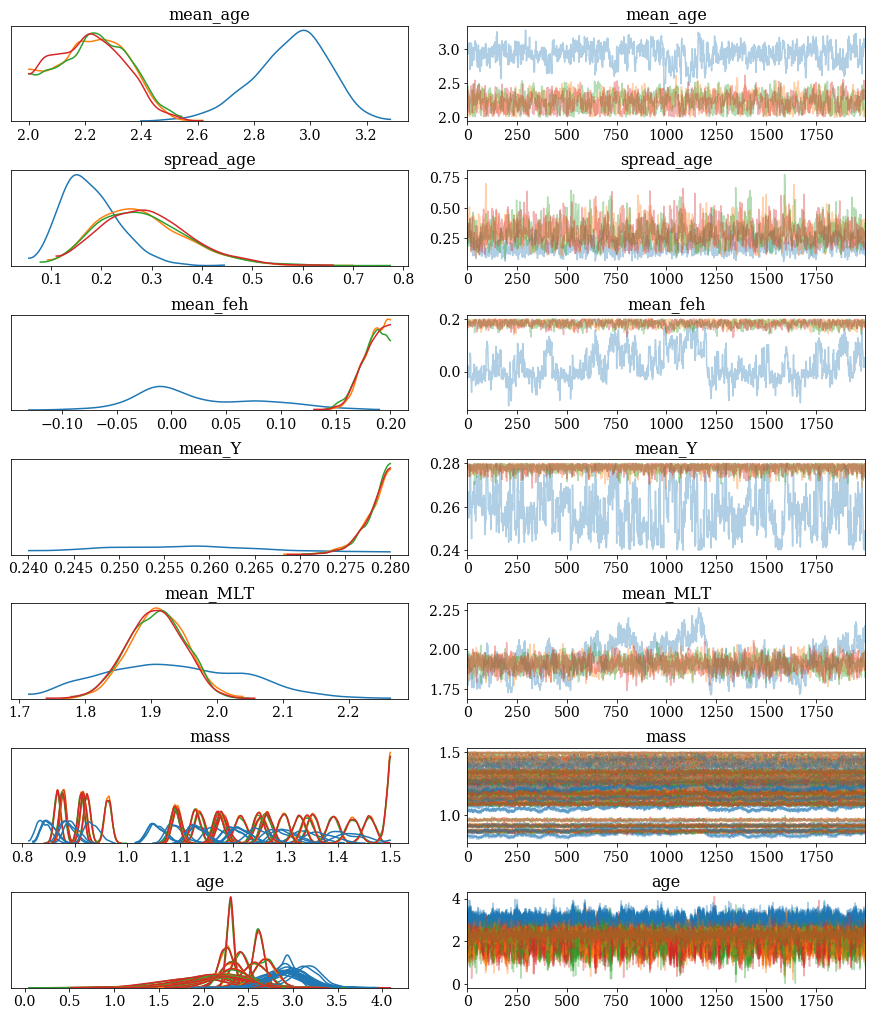

In [6]:
#trace plot
pm.plots.traceplot(trace,var_names=['mean_age','spread_age','mean_feh','mean_Y','mean_MLT','mass','age'],compact=True)
plt.show()

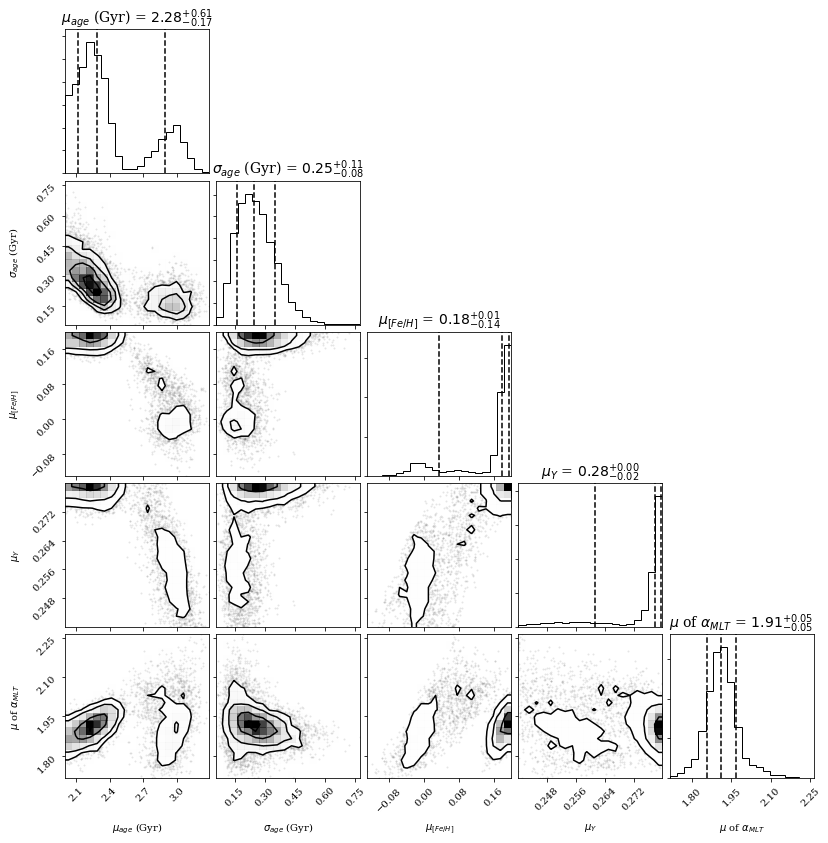

In [7]:
#corner plots
corner.corner(np.array([trace['mean_age'],trace['spread_age'],trace['mean_feh'],trace['mean_Y'],trace['mean_MLT']]).T,
              labels=[r'$\mu_{age}$ (Gyr)',r'$\sigma_{age}$ (Gyr)',r'$\mu_{[Fe/H]}$',
                      r'$\mu_{Y}$',r'$\mu$ of $\alpha_{MLT}$'],
             quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 14})
plt.show()

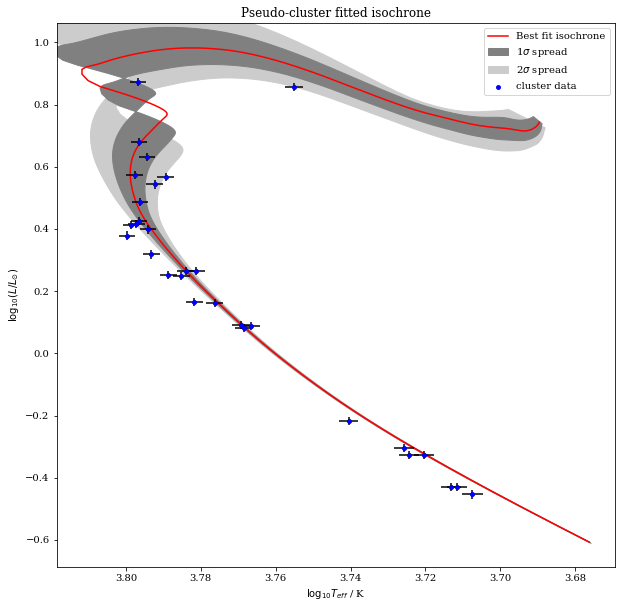

In [8]:
HBMplot.fittedIso(trace, m1.model, cluster_df, 'Pseudo-cluster fitted isochrone', cluster_type='pseudo')

In [9]:
def saveResults(trace, path):
    result_dict={}
    for parameter in ['mean_age','spread_age','mean_feh','mean_Y','mean_MLT']:
        median = np.percentile(trace[parameter],50)
        low_err = median-np.percentile(trace[parameter],15.9)
        high_err = np.percentile(trace[parameter],84.1)-median
        result_dict[parameter+'_est'] = median
        result_dict[parameter+'_low_err'] = low_err
        result_dict[parameter+'_high_err'] = high_err
    result_df = pd.DataFrame(result_dict, index=[1])
    result_df.to_csv(path,index=False)

saveResults(trace,'data_collection/NNcluster/Y_results/0.26.csv')